# Implement Article:
`CNN Model for Image Classification on MNIST and Fashion-MNIST Dataset`

Import Libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision import datasets, transforms
from torch import nn, optim
from torchinfo import summary
from torchmetrics import Accuracy, Precision, F1Score

Set device cuda if available

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Use `transforms`:

1.   data to tensors
2.   normalize data -1 to 1

In [7]:
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5) , ( 0.5))])

### Q2-1

Download Datas

In [ ]:
dataset_train = datasets.FashionMNIST(root = './datas' , download=True , transform=tf , train=True)
dataset_test  = datasets.FashionMNIST(root = './datas' , download=False , transform=tf , train=False)

Name of classes

In [9]:
classes = dict(zip(range(10) ,dataset_train.classes))
print(classes)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


Split datasets into new order `80:20`

In [10]:
full_dataset = ConcatDataset([dataset_train, dataset_test])
train_size =int( (len(dataset_train) + len(dataset_test) ) * 0.8)
test_size = (len(dataset_train) + len(dataset_test) ) - train_size
train_set, test_set = random_split(full_dataset, [train_size, test_size])

In [11]:
print(f'train set size: {len(train_set)}')
print(f'test set size: {len(test_set)}')

train set size: 56000
test set size: 14000


Visualize Random data

In [ ]:
def Imshow(img):
  img = img/2 + 0.5 #denormalize
  npimg = img.numpy()
  plt.figure(figsize=(8,8))
  plt.imshow(npimg[0] , 'Greys')
  plt.axis('off')
  plt.show()

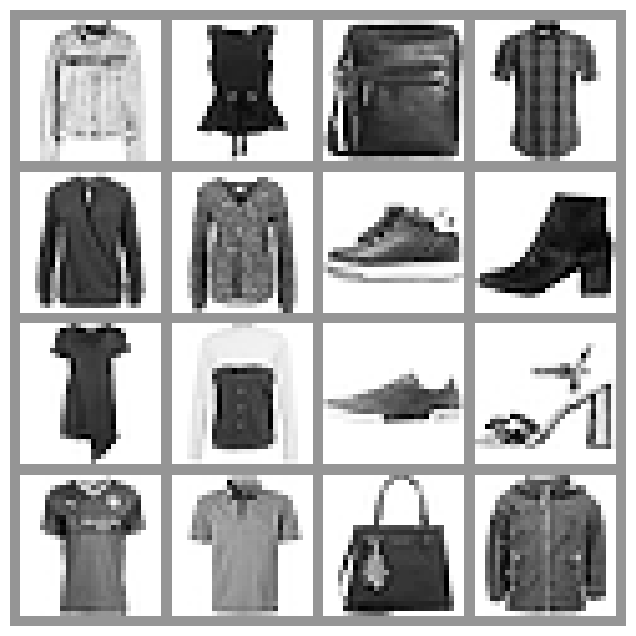

[['Coat', 'Shirt', 'Bag', 'Shirt'],
 ['Shirt', 'Shirt', 'Sneaker', 'Ankle boot'],
 ['T-shirt/top', 'Shirt', 'Sneaker', 'Sandal'],
 ['T-shirt/top', 'T-shirt/top', 'Bag', 'Coat']]

In [ ]:
torch.manual_seed(15)
images , labels = next(iter(DataLoader(train_set , 16 , shuffle=True)))

Imshow(torchvision.utils.make_grid(images , 4))
[[classes[labels[4*j+i].item()] for i in range(int(16/4))] for j in range(int(16/4))]

## Network

Architecture 3 : *Define Network*
<br>
Paper's Optimal Parameters

*   Batch size = `128`
*   Activation function = `softmax`
*   Optimizer = `Adam`
*   Dropout = `0.25` after each pooling layer,
*   Epoch = `50`
*   Kernel size = `2×2`

In [12]:
class Net_architecture_3(nn.Module):
    def __init__(self):
        super(Net_architecture_3 , self).__init__()
        
        self.Conv2D_1 = nn.Conv2d(1 , 64 , 2)
        # POOLING
        self.dropout_1 = nn.Dropout(0.25)
        self.Conv2D_2 = nn.Conv2d(64 , 64 , 2)
        # POOLING
        self.dropout_2 = nn.Dropout(0.25)
        self.Conv2D_3 = nn.Conv2d(64 , 64 , 2)
        self.dropout_3 = nn.Dropout(0.25)
        self.hidden_neurons = nn.Linear(64 * 5 * 5 , 64)
        self.dropout_4 = nn.Dropout(0.25)
        self.fc_out = nn.Linear(64 , 10)

    def forward(self , x):
        x = torch.softmax(self.Conv2D_1(x),-1)
        x = torch.max_pool2d(x , 2)
        x = self.dropout_1(x)
        x = torch.softmax(self.Conv2D_2(x),-1)
        x = torch.max_pool2d(x , 2)
        x = self.dropout_2(x)
        x = torch.softmax(self.Conv2D_3(x),-1)
        x = self.dropout_3(x)
        x = torch.flatten(x , 1)
        x = torch.softmax(self.hidden_neurons(x),-1)
        x = self.dropout_4(x)
        x = torch.softmax(self.fc_out(x) , -1)
        return x

In [ ]:
torch.manual_seed(15)
net3 = Net_architecture_3().to(device=device)
summary(net3 , (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 27, 27]             320
           Dropout-2           [-1, 64, 13, 13]               0
            Conv2d-3           [-1, 64, 12, 12]          16,448
           Dropout-4             [-1, 64, 6, 6]               0
            Conv2d-5             [-1, 64, 5, 5]          16,448
           Dropout-6             [-1, 64, 5, 5]               0
            Linear-7                   [-1, 64]         102,464
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 10]             650
Total params: 136,330
Trainable params: 136,330
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 0.52
Estimated Total Size (MB): 1.07
-------------------------------------------

Architecture 5 : *Define Network*
<br>
Paper's Optimal Parameters

*   Batch size = `128`
*   Activation function = `softmax`
*   Optimizer = `RMSprop`
*   Dropout = `0.25` after each pooling layer,
*   Epoch = `50`
*   Kernel size = `3×3`

In [13]:
class Net_architecture_5(nn.Module):
    def __init__(self):
        super(Net_architecture_5 , self).__init__()
        
        self.Conv2D_1 = nn.Conv2d(1 , 32 , 3)
        self.Conv2D_2 = nn.Conv2d(32 , 32 , 3)
        # POOLING
        self.dropout_1 = nn.Dropout(0.25)
        self.Conv2D_3 = nn.Conv2d(32 , 64 , 3)
        self.Conv2D_4 = nn.Conv2d(64 , 64 , 3)
        # POOLING
        self.dropout_2 = nn.Dropout(0.25)
        self.hidden_neurons = nn.Linear(64 * 4 * 4 , 512)
        self.dropout_3 = nn.Dropout(0.25)
        self.fc_out = nn.Linear(512 , 10)


    def forward(self , x):
        x = torch.softmax(self.Conv2D_1(x),-1)
        x = torch.relu(self.Conv2D_2(x))
        x = torch.max_pool2d(x , 2)
        x = self.dropout_1(x)
        x = torch.softmax(self.Conv2D_3(x),-1)
        x = torch.softmax(self.Conv2D_4(x),-1)
        x = torch.max_pool2d(x , 2)
        x = self.dropout_2(x)
        x = torch.flatten(x , 1)
        x = torch.softmax(self.hidden_neurons(x),-1)
        x = self.dropout_3(x)
        x = torch.softmax(self.fc_out(x) , -1)
        return x

In [ ]:
torch.manual_seed(15)
net5 = Net_architecture_5().to(device=device)
summary(net5 , (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
           Dropout-3           [-1, 32, 12, 12]               0
            Conv2d-4           [-1, 64, 10, 10]          18,496
            Conv2d-5             [-1, 64, 8, 8]          36,928
           Dropout-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 512]         524,800
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 10]           5,130
Total params: 594,922
Trainable params: 594,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 2.27
Estimated Total Size (MB): 2.71
-------------------------------------------

Set paper's Optimal Parameters

In [16]:
ep = 50
batch_size = 128
criterion = nn.CrossEntropyLoss()
# optimizer defined for each net later

## Train Nets

Dataloaders

In [17]:
trainloader = DataLoader(train_set , batch_size = batch_size , shuffle=True)
val_loader = DataLoader(test_set , batch_size = batch_size , shuffle=True)

### net3 - optimizer Adam

In [ ]:
net3 = Net_architecture_3().to(device)
optimizer = optim.Adam(net3.parameters())

loss_arr = np.array([])
val_loss_arr = np.array([])
for epoch in range(ep):

    train_loss = 0.0
    for i, data in enumerate(trainloader):
        img, label = data

        optimizer.zero_grad()
        output = net3(img.to(device))
        loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()
        train_loss = loss.item() + train_loss
    train_loss = train_loss / (i+1)
    loss_arr = np.append(loss_arr , train_loss)

    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
                img, label = data
                v_output = net3(img.to(device))
                v_loss = criterion(v_output , label.to(device))
                val_loss = val_loss + v_loss.item()
    val_loss = val_loss / (i+1)
    val_loss_arr = np.append(val_loss_arr , val_loss)
    
    print(f'epoch: {epoch :2d} , T-loss: {train_loss :.3f} , V-loss: {val_loss :.3f}')

epoch:  0 , T-loss: 2.300 , V-loss: 2.285
epoch:  1 , T-loss: 2.241 , V-loss: 2.214
epoch:  2 , T-loss: 2.200 , V-loss: 2.192
epoch:  3 , T-loss: 2.186 , V-loss: 2.183
epoch:  4 , T-loss: 2.180 , V-loss: 2.179
epoch:  5 , T-loss: 2.176 , V-loss: 2.175
epoch:  6 , T-loss: 2.168 , V-loss: 2.149
epoch:  7 , T-loss: 2.128 , V-loss: 2.123
epoch:  8 , T-loss: 2.117 , V-loss: 2.119
epoch:  9 , T-loss: 2.112 , V-loss: 2.113
epoch: 10 , T-loss: 2.109 , V-loss: 2.112
epoch: 11 , T-loss: 2.108 , V-loss: 2.112
epoch: 12 , T-loss: 2.107 , V-loss: 2.108
epoch: 13 , T-loss: 2.106 , V-loss: 2.111
epoch: 14 , T-loss: 2.106 , V-loss: 2.109
epoch: 15 , T-loss: 2.106 , V-loss: 2.109
epoch: 16 , T-loss: 2.103 , V-loss: 2.106
epoch: 17 , T-loss: 2.103 , V-loss: 2.110
epoch: 18 , T-loss: 2.104 , V-loss: 2.108
epoch: 19 , T-loss: 2.102 , V-loss: 2.107
epoch: 20 , T-loss: 2.104 , V-loss: 2.108
epoch: 21 , T-loss: 2.103 , V-loss: 2.107
epoch: 22 , T-loss: 2.101 , V-loss: 2.105
epoch: 23 , T-loss: 2.102 , V-loss

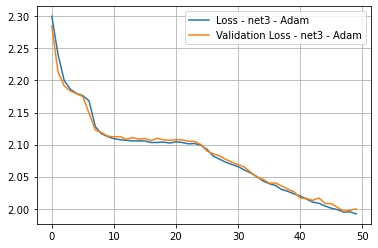

In [ ]:
plt.plot(loss_arr , label = 'Loss - net3 - Adam')
plt.plot(val_loss_arr , label = 'Validation Loss - net3 - Adam')
plt.grid()
plt.legend()
plt.show()

In [ ]:
path = './fation_net_arc3_adam.pth'
torch.save(net3.state_dict() , path)

### net 5 - optimizer RMSprop

In [ ]:
net5 = Net_architecture_5().to(device)
optimizer = optim.RMSprop(net5.parameters() , 0.001)

loss_arr = np.array([])
val_loss_arr = np.array([])

for epoch in range(ep):

    train_loss = 0.0
    for i, data in enumerate(trainloader):
        img, label = data

        optimizer.zero_grad()
        output = net5(img.to(device))
        loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()
        train_loss = loss.item() + train_loss
    train_loss = train_loss / (i+1)
    loss_arr = np.append(loss_arr , train_loss)

    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
                img, label = data
                v_output = net5(img.to(device))
                v_loss = criterion(v_output , label.to(device))
                val_loss = val_loss + v_loss.item()
    val_loss = val_loss / (i+1)
    val_loss_arr = np.append(val_loss_arr , val_loss)
    
    print(f'epoch: {epoch :2d} , T-loss: {train_loss :.3f} , V-loss: {val_loss :.3f}')

epoch:  0 , T-loss: 2.282 , V-loss: 2.266
epoch:  1 , T-loss: 2.253 , V-loss: 2.234
epoch:  2 , T-loss: 2.215 , V-loss: 2.198
epoch:  3 , T-loss: 2.188 , V-loss: 2.179
epoch:  4 , T-loss: 2.177 , V-loss: 2.174
epoch:  5 , T-loss: 2.171 , V-loss: 2.168
epoch:  6 , T-loss: 2.169 , V-loss: 2.166
epoch:  7 , T-loss: 2.167 , V-loss: 2.164
epoch:  8 , T-loss: 2.165 , V-loss: 2.164
epoch:  9 , T-loss: 2.166 , V-loss: 2.166
epoch: 10 , T-loss: 2.165 , V-loss: 2.161
epoch: 11 , T-loss: 2.165 , V-loss: 2.165
epoch: 12 , T-loss: 2.164 , V-loss: 2.163
epoch: 13 , T-loss: 2.162 , V-loss: 2.158
epoch: 14 , T-loss: 2.156 , V-loss: 2.157
epoch: 15 , T-loss: 2.146 , V-loss: 2.141
epoch: 16 , T-loss: 2.134 , V-loss: 2.129
epoch: 17 , T-loss: 2.121 , V-loss: 2.111
epoch: 18 , T-loss: 2.110 , V-loss: 2.109
epoch: 19 , T-loss: 2.102 , V-loss: 2.098
epoch: 20 , T-loss: 2.096 , V-loss: 2.090
epoch: 21 , T-loss: 2.090 , V-loss: 2.085
epoch: 22 , T-loss: 2.085 , V-loss: 2.085
epoch: 23 , T-loss: 2.079 , V-loss

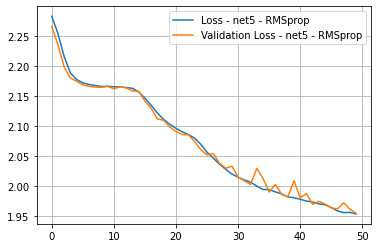

In [ ]:
plt.plot(loss_arr , label = 'Loss - net5 - RMSprop')
plt.plot(val_loss_arr , label = 'Validation Loss - net5 - RMSprop')
plt.grid()
plt.legend()
plt.show()

In [ ]:
path = './fation_net_arc5_RMSprop.pth'
torch.save(net5.state_dict() , path)

### net5 - optimizer Adam

In [ ]:
net5 = Net_architecture_5().to(device)
optimizer = optim.Adam(net5.parameters())

loss_arr = np.array([])
val_loss_arr = np.array([])

for epoch in range(ep):

    train_loss = 0.0
    for i, data in enumerate(trainloader):
        img, label = data

        optimizer.zero_grad()
        output = net5(img.to(device))
        loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()
        train_loss = loss.item() + train_loss
    train_loss = train_loss / (i+1)
    loss_arr = np.append(loss_arr , train_loss)

    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
                img, label = data
                v_output = net5(img.to(device))
                v_loss = criterion(v_output , label.to(device))
                val_loss = val_loss + v_loss.item()
    val_loss = val_loss / (i+1)
    val_loss_arr = np.append(val_loss_arr , val_loss)
    
    print(f'epoch: {epoch :2d} , T-loss: {train_loss :.3f} , V-loss: {val_loss :.3f}')

epoch:  0 , T-loss: 2.288 , V-loss: 2.252
epoch:  1 , T-loss: 2.226 , V-loss: 2.208
epoch:  2 , T-loss: 2.199 , V-loss: 2.192
epoch:  3 , T-loss: 2.186 , V-loss: 2.183
epoch:  4 , T-loss: 2.180 , V-loss: 2.180
epoch:  5 , T-loss: 2.177 , V-loss: 2.177
epoch:  6 , T-loss: 2.174 , V-loss: 2.174
epoch:  7 , T-loss: 2.173 , V-loss: 2.174
epoch:  8 , T-loss: 2.171 , V-loss: 2.172
epoch:  9 , T-loss: 2.170 , V-loss: 2.171
epoch: 10 , T-loss: 2.169 , V-loss: 2.170
epoch: 11 , T-loss: 2.169 , V-loss: 2.169
epoch: 12 , T-loss: 2.168 , V-loss: 2.170
epoch: 13 , T-loss: 2.168 , V-loss: 2.169
epoch: 14 , T-loss: 2.167 , V-loss: 2.167
epoch: 15 , T-loss: 2.162 , V-loss: 2.161
epoch: 16 , T-loss: 2.149 , V-loss: 2.146
epoch: 17 , T-loss: 2.136 , V-loss: 2.126
epoch: 18 , T-loss: 2.096 , V-loss: 2.087
epoch: 19 , T-loss: 2.077 , V-loss: 2.075
epoch: 20 , T-loss: 2.068 , V-loss: 2.070
epoch: 21 , T-loss: 2.062 , V-loss: 2.066
epoch: 22 , T-loss: 2.056 , V-loss: 2.058
epoch: 23 , T-loss: 2.051 , V-loss

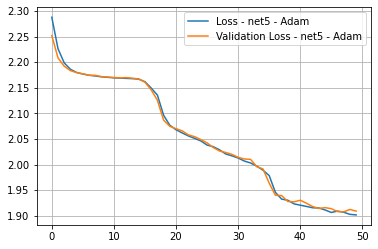

In [ ]:
plt.plot(loss_arr , label = 'Loss - net5 - Adam')
plt.plot(val_loss_arr , label = 'Validation Loss - net5 - Adam')
plt.grid()
plt.legend()
plt.show()

In [ ]:
path = './fation_net_arc5_Adam.pth'
torch.save(net5.state_dict() , path)

### net3 - optimizer SGD

In [ ]:
net3 = Net_architecture_3().to(device)
optimizer = optim.SGD(net3.parameters() , 0.001)

loss_arr = np.array([])
val_loss_arr = np.array([])
for epoch in range(ep):

    train_loss = 0.0
    for i, data in enumerate(trainloader):
        img, label = data

        optimizer.zero_grad()
        output = net3(img.to(device))
        loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()
        train_loss = loss.item() + train_loss
    train_loss = train_loss / (i+1)
    loss_arr = np.append(loss_arr , train_loss)

    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
                img, label = data
                v_output = net3(img.to(device))
                v_loss = criterion(v_output , label.to(device))
                val_loss = val_loss + v_loss.item()
    val_loss = val_loss / (i+1)
    val_loss_arr = np.append(val_loss_arr , val_loss)
    
    print(f'epoch: {epoch :2d} , T-loss: {train_loss :.3f} , V-loss: {val_loss :.3f}')

epoch:  0 , T-loss: 2.303 , V-loss: 2.303
epoch:  1 , T-loss: 2.303 , V-loss: 2.303
epoch:  2 , T-loss: 2.303 , V-loss: 2.303
epoch:  3 , T-loss: 2.303 , V-loss: 2.303
epoch:  4 , T-loss: 2.303 , V-loss: 2.303
epoch:  5 , T-loss: 2.303 , V-loss: 2.303
epoch:  6 , T-loss: 2.303 , V-loss: 2.303
epoch:  7 , T-loss: 2.303 , V-loss: 2.303
epoch:  8 , T-loss: 2.303 , V-loss: 2.303
epoch:  9 , T-loss: 2.303 , V-loss: 2.303
epoch: 10 , T-loss: 2.303 , V-loss: 2.303
epoch: 11 , T-loss: 2.303 , V-loss: 2.303
epoch: 12 , T-loss: 2.303 , V-loss: 2.303
epoch: 13 , T-loss: 2.303 , V-loss: 2.303
epoch: 14 , T-loss: 2.303 , V-loss: 2.303
epoch: 15 , T-loss: 2.303 , V-loss: 2.303
epoch: 16 , T-loss: 2.303 , V-loss: 2.303
epoch: 17 , T-loss: 2.303 , V-loss: 2.303
epoch: 18 , T-loss: 2.303 , V-loss: 2.303
epoch: 19 , T-loss: 2.303 , V-loss: 2.303
epoch: 20 , T-loss: 2.303 , V-loss: 2.303
epoch: 21 , T-loss: 2.303 , V-loss: 2.303
epoch: 22 , T-loss: 2.303 , V-loss: 2.303
epoch: 23 , T-loss: 2.303 , V-loss

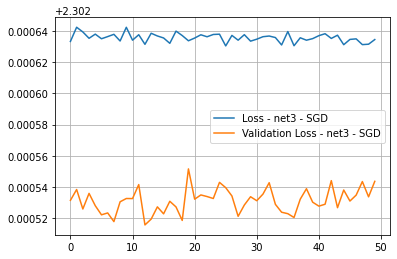

In [ ]:
plt.plot(loss_arr , label = 'Loss - net3 - SGD')
plt.plot(val_loss_arr , label = 'Validation Loss - net3 - SGD')
plt.grid()
plt.legend()
plt.show()

In [ ]:
path = './fation_net_arc3_SGD.pth'
torch.save(net3.state_dict() , path)

### net5 - optimizer SGD

In [ ]:
net5 = Net_architecture_5().to(device)
optimizer = optim.SGD(net5.parameters() , 0.001)

loss_arr = np.array([])
val_loss_arr = np.array([])

for epoch in range(ep):

    train_loss = 0.0
    for i, data in enumerate(trainloader):
        img, label = data

        optimizer.zero_grad()
        output = net5(img.to(device))
        loss = criterion(output, label.to(device))
        loss.backward()
        optimizer.step()
        train_loss = loss.item() + train_loss
    train_loss = train_loss / (i+1)
    loss_arr = np.append(loss_arr , train_loss)

    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
                img, label = data
                v_output = net5(img.to(device))
                v_loss = criterion(v_output , label.to(device))
                val_loss = val_loss + v_loss.item()
    val_loss = val_loss / (i+1)
    val_loss_arr = np.append(val_loss_arr , val_loss)
    
    print(f'epoch: {epoch :2d} , T-loss: {train_loss :.3f} , V-loss: {val_loss :.3f}')

epoch:  0 , T-loss: 2.303 , V-loss: 2.303
epoch:  1 , T-loss: 2.303 , V-loss: 2.303
epoch:  2 , T-loss: 2.303 , V-loss: 2.303
epoch:  3 , T-loss: 2.303 , V-loss: 2.303
epoch:  4 , T-loss: 2.303 , V-loss: 2.303
epoch:  5 , T-loss: 2.303 , V-loss: 2.303
epoch:  6 , T-loss: 2.303 , V-loss: 2.303
epoch:  7 , T-loss: 2.303 , V-loss: 2.303
epoch:  8 , T-loss: 2.303 , V-loss: 2.303
epoch:  9 , T-loss: 2.303 , V-loss: 2.303
epoch: 10 , T-loss: 2.303 , V-loss: 2.303
epoch: 11 , T-loss: 2.303 , V-loss: 2.303
epoch: 12 , T-loss: 2.303 , V-loss: 2.303
epoch: 13 , T-loss: 2.303 , V-loss: 2.303
epoch: 14 , T-loss: 2.303 , V-loss: 2.303
epoch: 15 , T-loss: 2.303 , V-loss: 2.303
epoch: 16 , T-loss: 2.303 , V-loss: 2.303
epoch: 17 , T-loss: 2.303 , V-loss: 2.303
epoch: 18 , T-loss: 2.303 , V-loss: 2.303
epoch: 19 , T-loss: 2.303 , V-loss: 2.303
epoch: 20 , T-loss: 2.303 , V-loss: 2.303
epoch: 21 , T-loss: 2.303 , V-loss: 2.303
epoch: 22 , T-loss: 2.303 , V-loss: 2.303
epoch: 23 , T-loss: 2.303 , V-loss

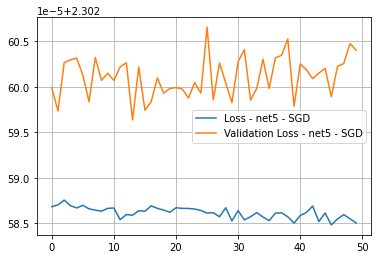

In [ ]:
plt.plot(loss_arr , label = 'Loss - net5 - SGD')
plt.plot(val_loss_arr , label = 'Validation Loss - net5 - SGD')
plt.grid()
plt.legend()
plt.show()

In [ ]:
path = './fation_net_arc5_SGD.pth'
torch.save(net5.state_dict() , path)

## Test Networks

In [18]:
testloader = DataLoader(dataset_test , len(dataset_test) , shuffle=False)
img_t , label_t = next(iter(testloader))

* accuracy
* precision
* f1-score

In [19]:
accuracy_score = Accuracy()
precision_score = Precision(average='macro', num_classes=10)
f1_score = F1Score(num_classes=10)

def predict(net , img , label):
    net.eval()
    with torch.no_grad():
        tp = torch.argmax(net(img.to(device)) , 1)
    accuracy = accuracy_score(tp.cpu() , label)
    precision = precision_score(tp.cpu() , label)
    f1 = f1_score(tp.cpu() , label)
    return accuracy.item() , precision.item() , f1.item()

In [24]:
path3 = './fation_net_arc3_adam.pth'

net3 = Net_architecture_3().to(device)
net3.load_state_dict(torch.load(path3 , map_location=device))

predict(net3 , img_t , label_t)

(0.7146999835968018, 0.6258241534233093, 0.7146999835968018)

In [25]:
path5 = './fation_net_arc5_RMSprop.pth'

net5 = Net_architecture_5().to(device)
net5.load_state_dict(torch.load(path5 , map_location=device))

predict(net5 , img_t , label_t)

(0.8079000115394592, 0.751121461391449, 0.8079000115394592)

In [27]:
path5 = './fation_net_arc5_Adam.pth'

net5 = Net_architecture_5().to(device)
net5.load_state_dict(torch.load(path5 , map_location=device))

predict(net5 , img_t , label_t)

(0.7716000080108643, 0.7311774492263794, 0.771600067615509)

In [26]:
path3 = './fation_net_arc3_SGD.pth'

net3 = Net_architecture_3().to(device)
net3.load_state_dict(torch.load(path3 , map_location=device))

predict(net3 , img_t , label_t)

(0.10000000149011612, 0.010000000707805157, 0.10000000894069672)

In [28]:
path5 = './fation_net_arc5_SGD.pth'

net5 = Net_architecture_5().to(device)
net5.load_state_dict(torch.load(path5 , map_location=device))

predict(net5 , img_t , label_t)

(0.10000000149011612, 0.010000000707805157, 0.10000000894069672)